### IMPORTAMOS LIBRERÍAS

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report

In [2]:
# Vamos a especificar algunas condiciones para los datos cargados con Pandas
pd.set_option('display.max_columns', None)

# Establecemos el tamaño para el plot
plt.rcParams['figure.figsize'] = (20, 6)

# Y las variables del fichero de entrada, el path y el nombre
INPUT_PATH = "./input_data"
FILE_NAME = "InputOutput_Results.csv"

### AHORA DEFINIMOS ALGUNAS FUNCIONES GENÉRICAS

In [3]:
def load_data(input_path, file_name):
    """
    Cargamos el fichero csv con un pequeño preprocesamiento de carga
    """
    df = pd.read_csv(os.path.join(input_path, file_name), sep=",")
    #df = df.drop(["Unnamed: 0"], axis=1)
    df = df.drop(["caseID", "EnvID"], axis=1)
    df = df.sort_values(["EnvTime"])
    return df

### CARGAMOS LOS DATOS Y HACEMOS LA EXPLORACIÓN INICIAL

In [4]:
# Y aquí cargamos el fichero usando la función de carga
df_input = load_data(INPUT_PATH, FILE_NAME)
print(f"DataFrame dimensions: {df_input.shape}")

DataFrame dimensions: (50000, 20)


In [5]:
df_input

EnvTime  WindSpeed  WindDir  WaveHs  WaveTp  WaveDir  \
10730  1993-01-01 14:00:00     10.493   11.048   1.854  10.375   59.365   
27659  1993-01-01 19:00:00     11.648    0.237   1.921   5.672   39.220   
4668   1993-01-02 00:00:00     11.305   12.199   2.092   6.248   44.343   
34204  1993-01-02 05:00:00     12.637   19.779   2.617   7.524   50.553   
42613  1993-01-03 07:00:00     13.298    1.477   2.625   6.870   15.491   
...                    ...        ...      ...     ...     ...      ...   
14546  2022-07-30 20:00:00      7.262    4.920   1.374   6.877   54.435   
32963  2022-07-31 13:00:00      8.473  181.971   0.876   3.847  131.836   
14846  2022-07-31 17:00:00      9.576  153.957   1.094   4.201  151.651   
26161  2022-07-31 19:00:00      8.871  155.872   1.142   4.848  150.755   
43691  2022-07-31 21:00:00      8.454  156.364   1.142   4.836  149.700   

       CurrSpeed  CurrDir       x0        y0     dist0  heading0  \
10730      0.200   76.126  963.511 -1309.358  1625.660     215.0   
27659      0.147  133.069  992.718 -1253.251  1598.789     200.0   
4668       0.197   54.897  974.868 -1291.530  1618.152     210.0   
34204      0.233  114.515  950.643 -1326.127  1631.666     220.0   
42613      0.359  131.973  999.074 -1233.092  1587.030     195.0   
...          ...      ...      ...       ...       ...       ...   
14546      0.195   33.499  974.868 -1291.530  1618.152     210.0   
32963      0.188  168.551  526.411 -1212.455  1321.800     350.0   
14846      0.185  187.977  545.432 -1272.780  1384.726     335.0   
26161      0.056  189.660  545.432 -1272.780  1384.726     335.0   
43691      0.038  148.736  545.432 -1272.780  1384.726     335.0   

       time_closest  x_closest  y_closest  dist_closest  heading_closest  \
10730          -1.0    963.511  -1309.358      1625.660          215.000   
27659          -1.0    992.718  -1253.251      1598.789          200.000   
4668           -1.0    974.868  -1291.530      1618.152          210.000   
34204          -1.0    950.643  -1326.127      1631.666          220.000   
42613          -1.0    999.074  -1233.092      1587.030          195.000   
...             ...        ...        ...           ...              ...   
14546          -1.0    974.868  -1291.530      1618.152          210.000   
32963         493.3    434.102  -1236.069      1310.081            5.682   
14846          98.0    540.745  -1274.739      1384.689          334.857   
26161          -0.5    545.432  -1272.780      1384.726          335.000   
43691          -0.5    545.432  -1272.780      1384.726          335.000   

       DriftDirection_closest  velocity_closest  HitBool  
10730                   0.000             0.000        0  
27659                   0.000             0.000        0  
4668                    0.000             0.000        0  
34204                   0.000             0.000        0  
42613                   0.000             0.000        0  
...                       ...               ...      ...  
14546                   0.000             0.000        0  
32963                 160.644             0.386        0  
14846                 157.024             0.102        0  
26161                 155.307             0.000        0  
43691                 153.903             0.000        0  

[50000 rows x 20 columns]

In [6]:
# Vamos a analizar la estructura del dataset
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 10730 to 43691
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EnvTime                 50000 non-null  object 
 1   WindSpeed               50000 non-null  float64
 2   WindDir                 50000 non-null  float64
 3   WaveHs                  50000 non-null  float64
 4   WaveTp                  50000 non-null  float64
 5   WaveDir                 50000 non-null  float64
 6   CurrSpeed               50000 non-null  float64
 7   CurrDir                 50000 non-null  float64
 8   x0                      50000 non-null  float64
 9   y0                      50000 non-null  float64
 10  dist0                   50000 non-null  float64
 11  heading0                50000 non-null  float64
 12  time_closest            50000 non-null  float64
 13  x_closest               50000 non-null  float64
 14  y_closest               50000 non-null 

In [7]:
# Resumen de los estadísticos
df_input.describe()

WindSpeed       WindDir        WaveHs        WaveTp       WaveDir  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       8.547977    166.403106      1.996883      8.153029    151.001704   
std        3.832801    106.954322      1.097061      2.450247     91.970945   
min        2.000000      0.003000      0.094000      2.056000      0.012000   
25%        5.601750     76.361500      1.149000      6.364000     85.664000   
50%        8.306000    148.213000      1.784000      7.775000    141.347500   
75%       11.235000    278.113000      2.634000      9.458000    175.150500   
max       23.510000    359.999000      5.498000     23.696000    359.998000   

          CurrSpeed       CurrDir            x0            y0         dist0  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.210788    151.207480    750.475227  -1237.362360   1458.803036   
std        0.108053     91.781627    170.139422    158.317734    142.067939   
min        0.000000      0.000000    522.730000  -1412.680000   1156.084000   
25%        0.129000     86.293250    579.417000  -1368.861000   1342.558000   
50%        0.199000    142.490500    743.912000  -1291.530000   1472.468000   
75%        0.279000    189.300750    920.777000  -1128.305000   1595.765000   
max        0.781000    359.891000   1007.330000   -928.080000   1640.430000   

          heading0  time_closest     x_closest     y_closest  dist_closest  \
count  50000.00000  50000.000000  50000.000000  50000.000000  50000.000000   
mean     231.42070    496.875792    704.623080  -1136.118150   1397.126891   
std       94.61408   1306.262187    301.891308    390.624843    281.099863   
min        0.00000     -1.000000  -1072.017000  -1491.650000      0.414000   
25%      160.00000     -1.000000    566.549000  -1380.218000   1327.188750   
50%      255.00000     -1.000000    743.912000  -1291.530000   1471.305500   
75%      315.00000    553.000000    963.511000  -1128.305000   1595.765000   
max      355.00000  36000.000000   1369.871000    392.255000   1640.430000   

       heading_closest  DriftDirection_closest  velocity_closest       HitBool  
count     50000.000000            50000.000000      50000.000000  50000.000000  
mean        229.983329              107.499275          0.205877      0.010620  
std          90.108607              119.188732          0.355810      0.102506  
min           0.017000                0.000000          0.000000      0.000000  
25%         180.000000                0.000000          0.000000      0.000000  
50%         245.000000                0.000000          0.000000      0.000000  
75%         305.000000              176.344500          0.340000      0.000000  
max         359.987000              356.165000          2.075000      1.000000

In [8]:
df_statistics = pd.DataFrame(df_input.describe())
df_statistics.to_csv("df_statistics", sep='\t', encoding='utf-8', index=False, header=True)

In [9]:
# Comprobar si existen valores faltantes
missing_values = df_input.isnull().sum()
missing_values

EnvTime                   0
WindSpeed                 0
WindDir                   0
WaveHs                    0
WaveTp                    0
WaveDir                   0
CurrSpeed                 0
CurrDir                   0
x0                        0
y0                        0
dist0                     0
heading0                  0
time_closest              0
x_closest                 0
y_closest                 0
dist_closest              0
heading_closest           0
DriftDirection_closest    0
velocity_closest          0
HitBool                   0
dtype: int64

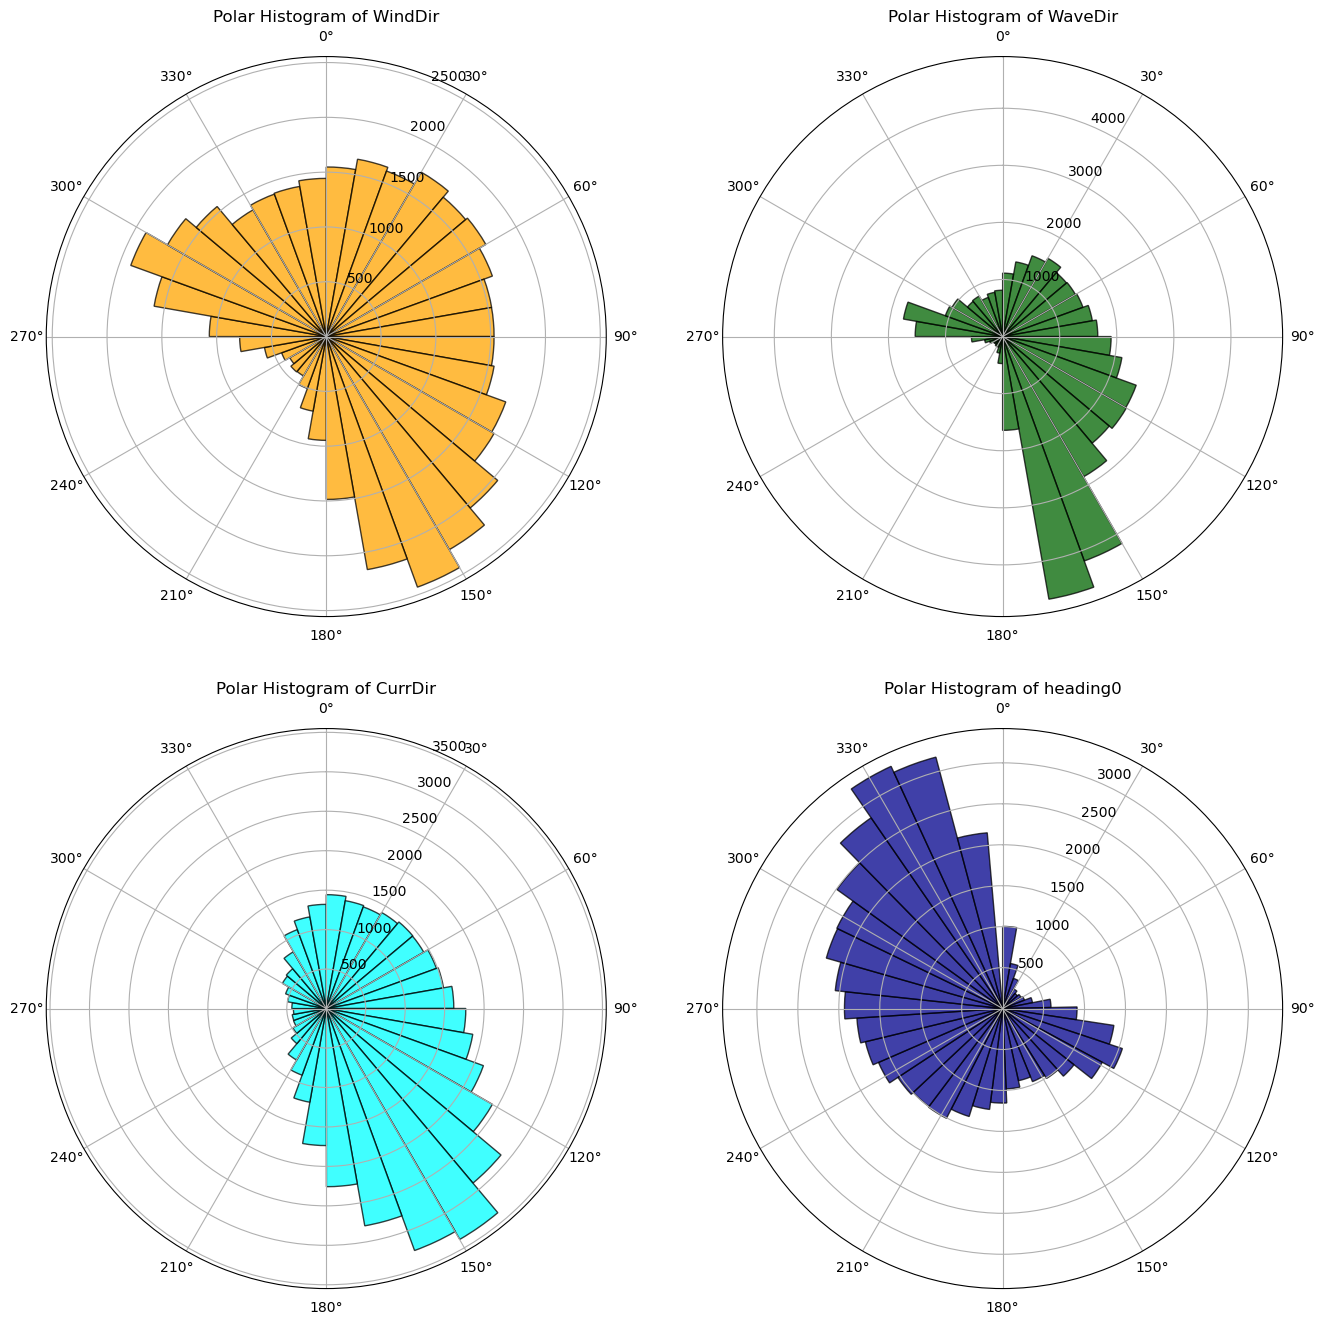

In [10]:
# Convert WindDir to radians
wind_dir_radians = np.deg2rad(df_input['WindDir'])
wave_dir_radians = np.deg2rad(df_input['WaveDir'])
curr_dir_radians = np.deg2rad(df_input['CurrDir'])
heading0_dir_radians = np.deg2rad(df_input['heading0'])

# Convert EnvTime to datetime
df_input['EnvTime'] = pd.to_datetime(df_input['EnvTime'])

# Plot polar histograms
plt.figure(figsize=(16, 16))

ax = plt.subplot(221, polar=True)
ax.hist(wind_dir_radians, bins=36, edgecolor='black', alpha=0.75, color='orange')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
ax.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
plt.title('Polar Histogram of WindDir')

ax = plt.subplot(222, polar=True)
ax.hist(wave_dir_radians, bins=36, edgecolor='black', alpha=0.75, color='darkgreen')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
ax.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
plt.title('Polar Histogram of WaveDir')

ax = plt.subplot(223, polar=True)
ax.hist(curr_dir_radians, bins=36, edgecolor='black', alpha=0.75, color='cyan')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
ax.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
plt.title('Polar Histogram of CurrDir')

ax = plt.subplot(224, polar=True)
ax.hist(heading0_dir_radians, bins=36, edgecolor='black', alpha=0.75, color='darkblue')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
ax.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
plt.title('Polar Histogram of heading0')

plt.show()

In [11]:
# # Convert EnvTime to datetime
# df_input['EnvTime'] = pd.to_datetime(df_input['EnvTime'])

# # Extract month from EnvTime
# df_input_plot['Month'] = df_input['EnvTime'].dt.month

# # Convert WindDir to radians
# wind_dir_radians = np.deg2rad(df_input['WindDir'])

# # Create polar plot
# plt.figure(figsize=(12, 8))
# ax = plt.subplot(121, polar=True)
# ax.hist(wind_dir_radians, bins=36, edgecolor='black', alpha=0.75, color='blue')
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)
# ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
# ax.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
# plt.title('Polar Histogram of WindDir')

# # Group by month and calculate the mean WindDir
# monthly_wind_dir = df_input.groupby('Month')['WindDir'].mean()

# # Convert monthly mean WindDir to radians
# monthly_wind_dir_radians = np.deg2rad(monthly_wind_dir)

# # Create polar plot for seasonality
# ax2 = plt.subplot(122, polar=True)
# months = np.arange(1, 13)
# colors = plt.cm.viridis(months / 12)  # Use viridis colormap

# sc = ax2.scatter(monthly_wind_dir_radians, np.ones_like(monthly_wind_dir_radians),
#                  c=months, s=100, cmap='viridis', alpha=0.75)
# ax2.set_theta_zero_location('N')
# ax2.set_theta_direction(-1)
# ax2.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
# ax2.set_xticklabels([f'{deg}\u00b0' for deg in range(0, 360, 30)])
# plt.title('Seasonality of WindDir')

# # Add a color bar
# cbar = plt.colorbar(sc, ax=ax2, orientation='vertical', pad=0.1)
# cbar.set_label('Month')

# plt.show()


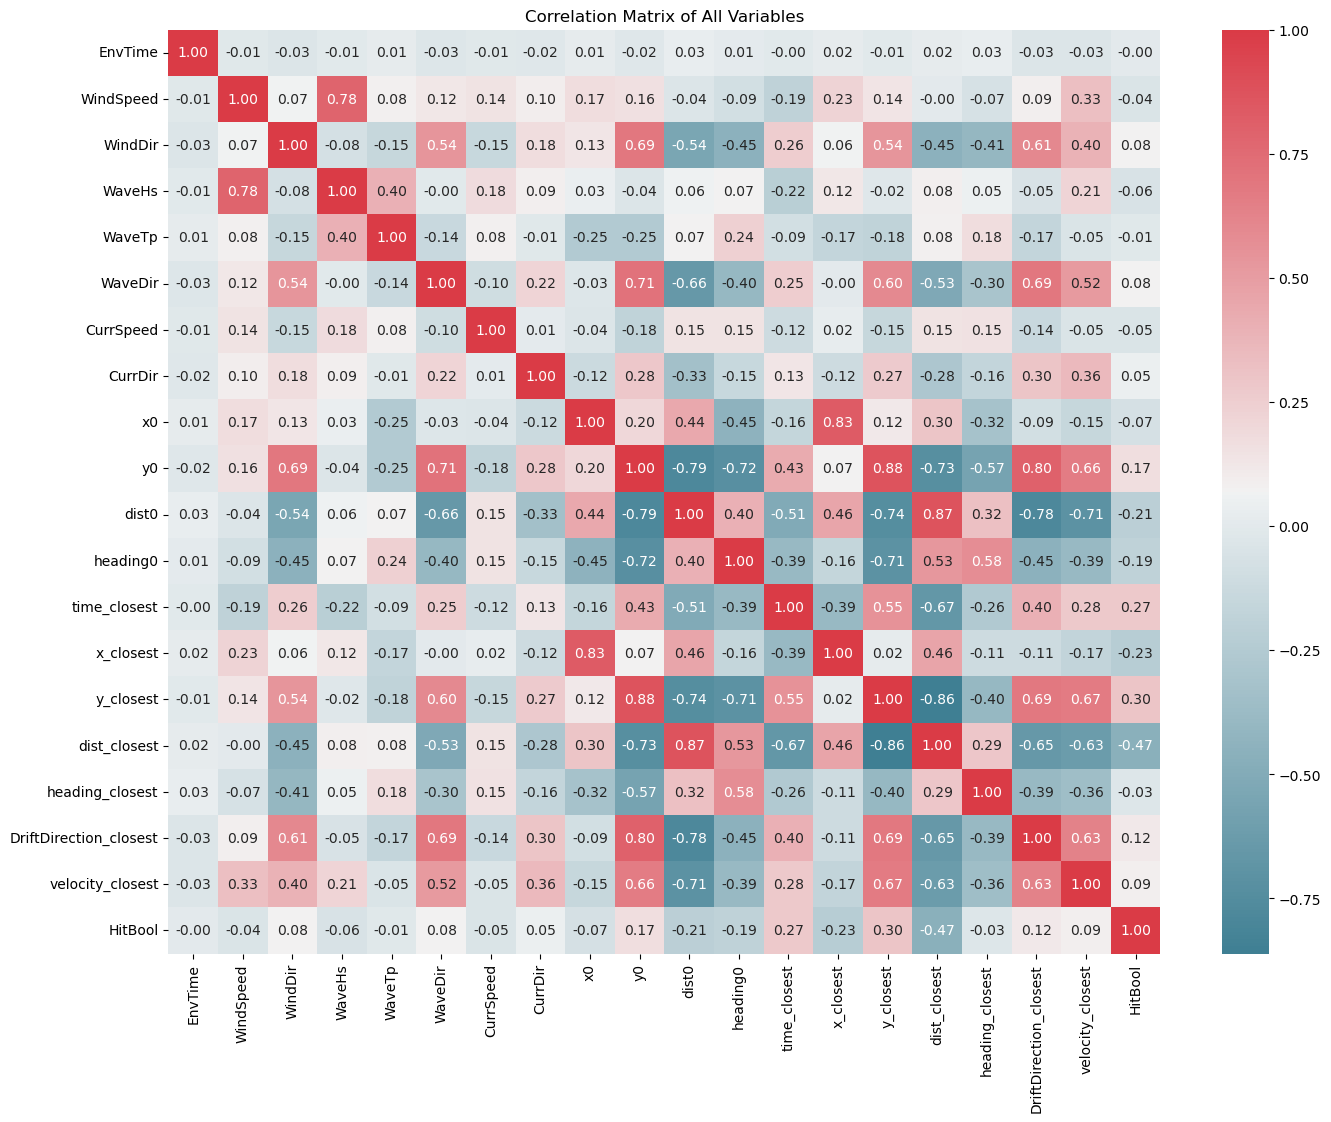

In [12]:
# Create a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# Compute correlation matrix
corr_matrix = df_input.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap)

plt.title("Correlation Matrix of All Variables")
plt.show()

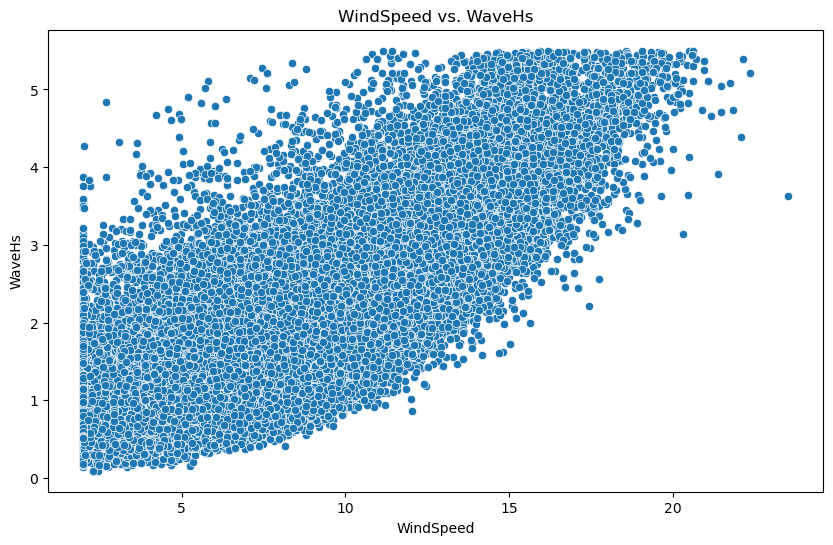

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WindSpeed', y='WaveHs', data=df_input)
plt.title('WindSpeed vs. WaveHs')
plt.show()

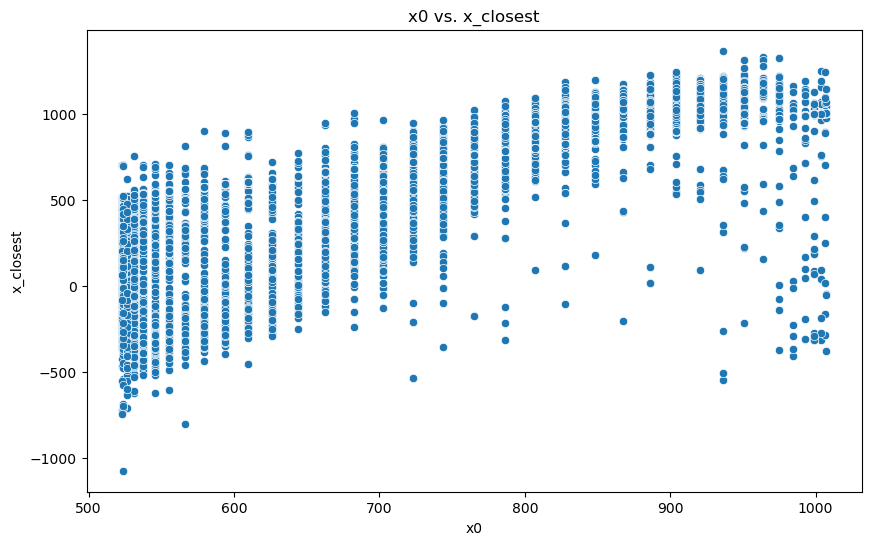

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x0', y='x_closest', data=df_input)
plt.title('x0 vs. x_closest')
plt.show()

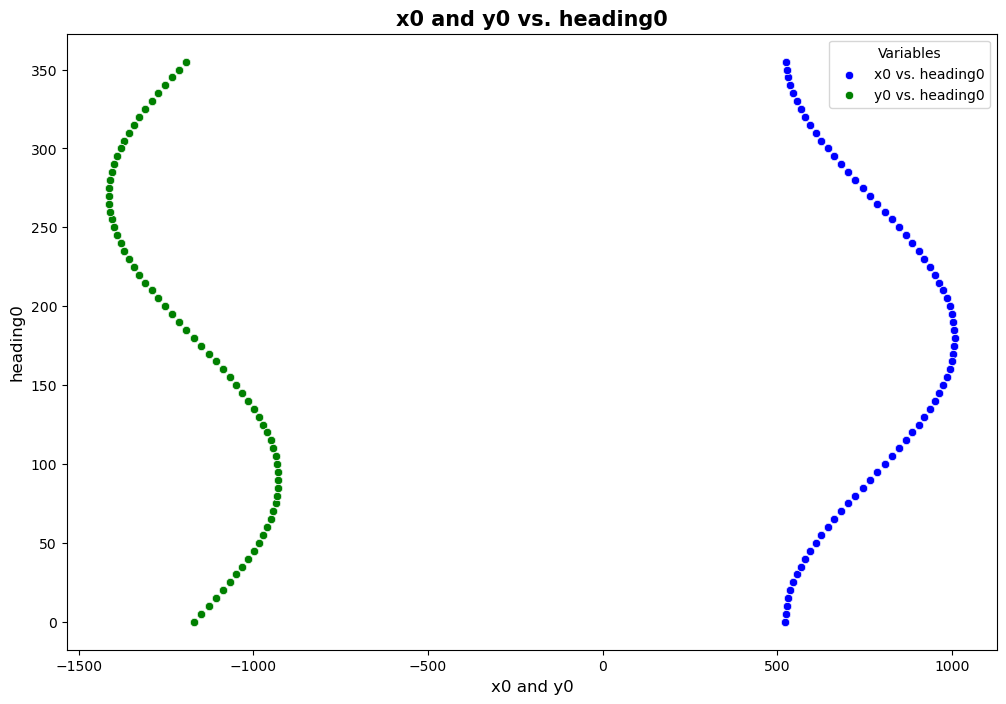

In [15]:

# Combined plot
plt.figure(figsize=(12, 8))

# Scatter plot: x0 vs. heading0
sns.scatterplot(x='x0', y='heading0', data=df_input, color='blue', label='x0 vs. heading0')

# Scatter plot: y0 vs. heading0
sns.scatterplot(x='y0', y='heading0', data=df_input, color='green', label='y0 vs. heading0')

plt.title('x0 and y0 vs. heading0', fontsize=15, fontweight='bold')
plt.xlabel('x0 and y0', fontsize=12)
plt.ylabel('heading0', fontsize=12)
plt.legend(title='Variables', loc='best')

# Display the plot
plt.show()

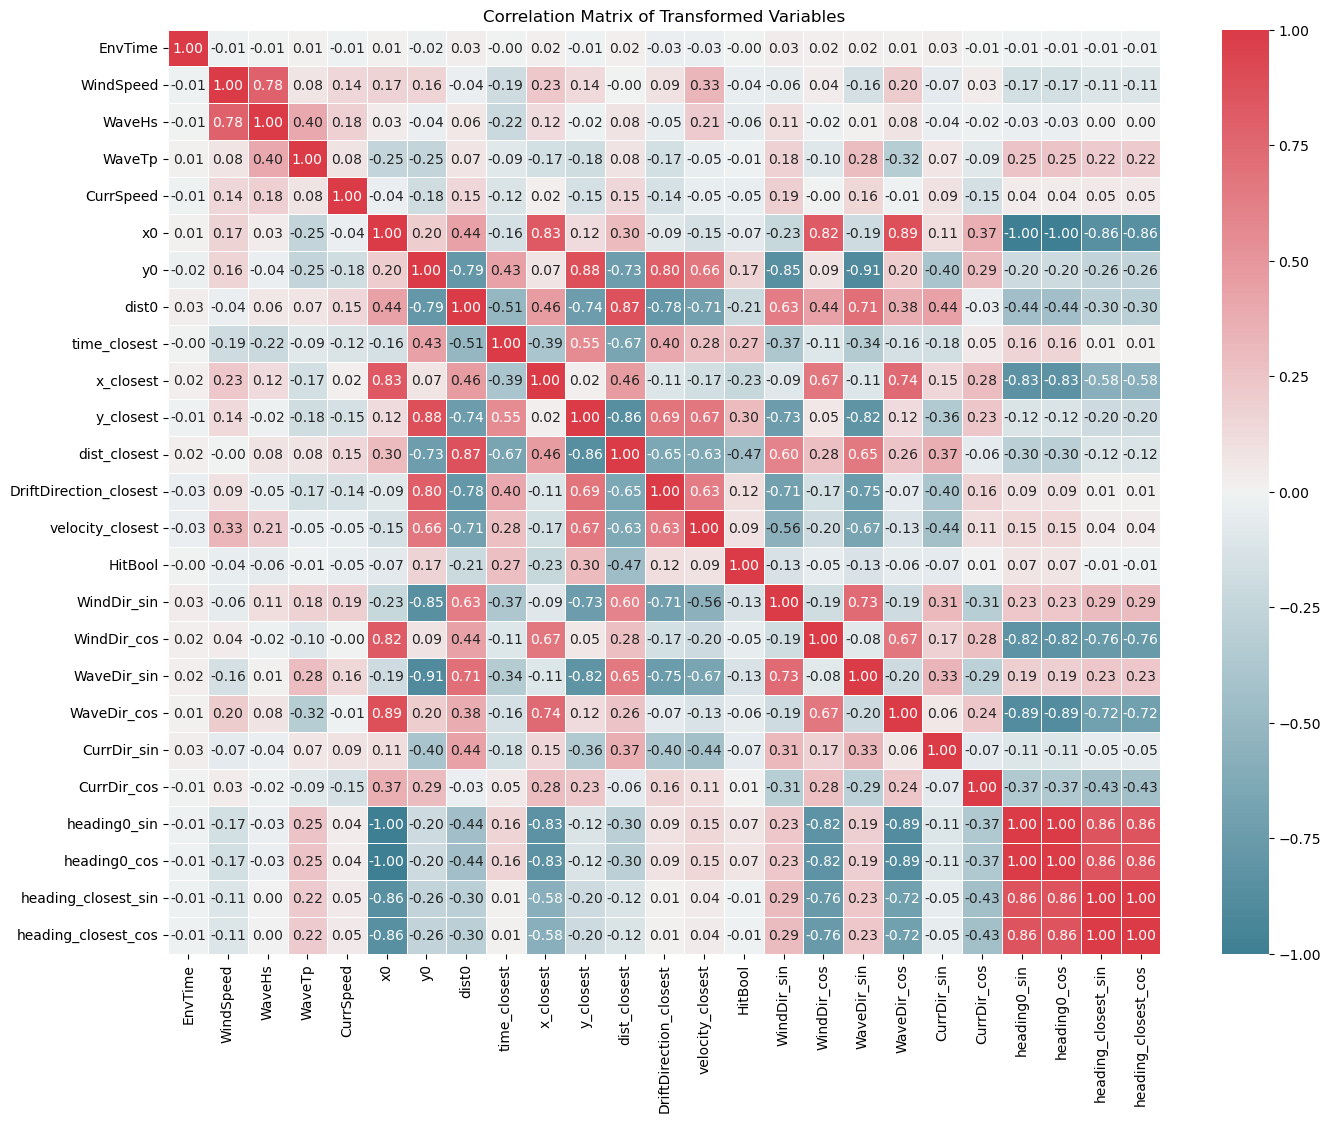

In [16]:
# Transforming directional data into sine and cosine components
df_input['WindDir_sin'] = np.sin(np.deg2rad(df_input['WindDir']))
df_input['WindDir_cos'] = np.cos(np.deg2rad(df_input['WindDir']))
df_input['WaveDir_sin'] = np.sin(np.deg2rad(df_input['WaveDir']))
df_input['WaveDir_cos'] = np.cos(np.deg2rad(df_input['WaveDir']))
df_input['CurrDir_sin'] = np.sin(np.deg2rad(df_input['CurrDir']))
df_input['CurrDir_cos'] = np.cos(np.deg2rad(df_input['CurrDir']))
df_input['heading0_sin'] = np.cos(np.deg2rad(df_input['heading0']))
df_input['heading0_cos'] = np.cos(np.deg2rad(df_input['heading0']))
df_input['heading_closest_sin'] = np.cos(np.deg2rad(df_input['heading_closest']))
df_input['heading_closest_cos'] = np.cos(np.deg2rad(df_input['heading_closest']))

# Drop the original directional columns
data_transformed = df_input.drop(columns=['WindDir', 'WaveDir', 'CurrDir', "heading0", "heading_closest"])

# Compute correlation matrix for transformed data
corr_matrix_transformed = data_transformed.corr()

# Visualize the new correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_transformed, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)
plt.title("Correlation Matrix of Transformed Variables")
plt.savefig('corrmatrixtransf.png')
plt.show()

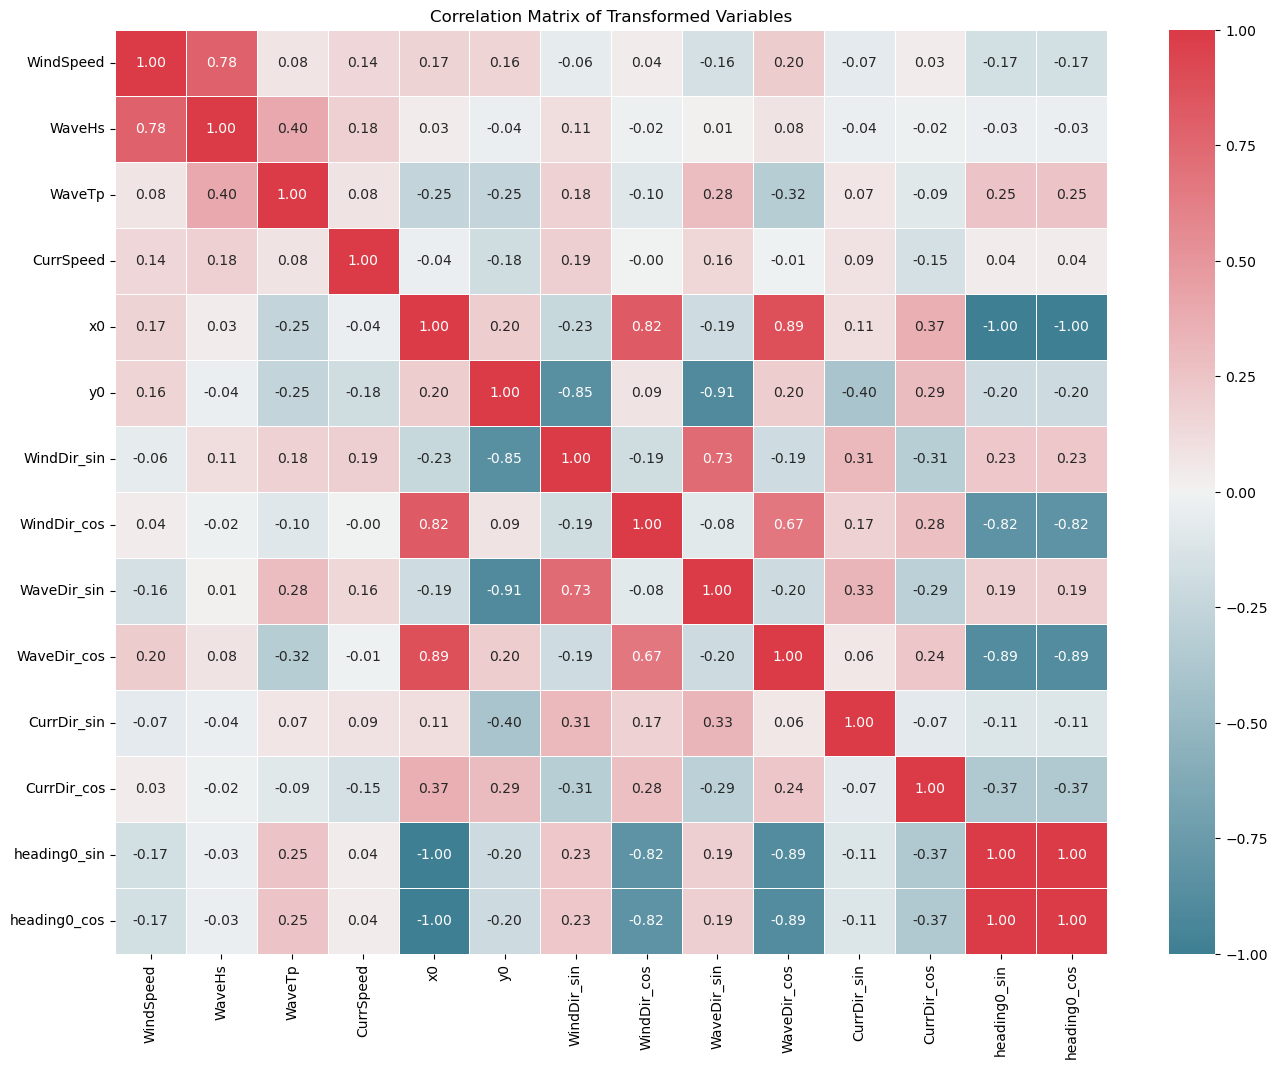

In [17]:
# Drop the original directional columns
data_transformed = df_input.drop(columns=["EnvTime","dist0","time_closest", "x_closest", "y_closest", "dist_closest", "DriftDirection_closest", "velocity_closest", "HitBool", "heading_closest_sin", "heading_closest_cos", 'WindDir', 'WaveDir', 'CurrDir', "heading0", "heading_closest"])

# Compute correlation matrix for transformed data
corr_matrix_transformed = data_transformed.corr()

# Visualize the new correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_transformed, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)
plt.title("Correlation Matrix of Transformed Variables")
plt.savefig('corrmatrixtransf.png')
plt.show()

In [18]:
data = df_input

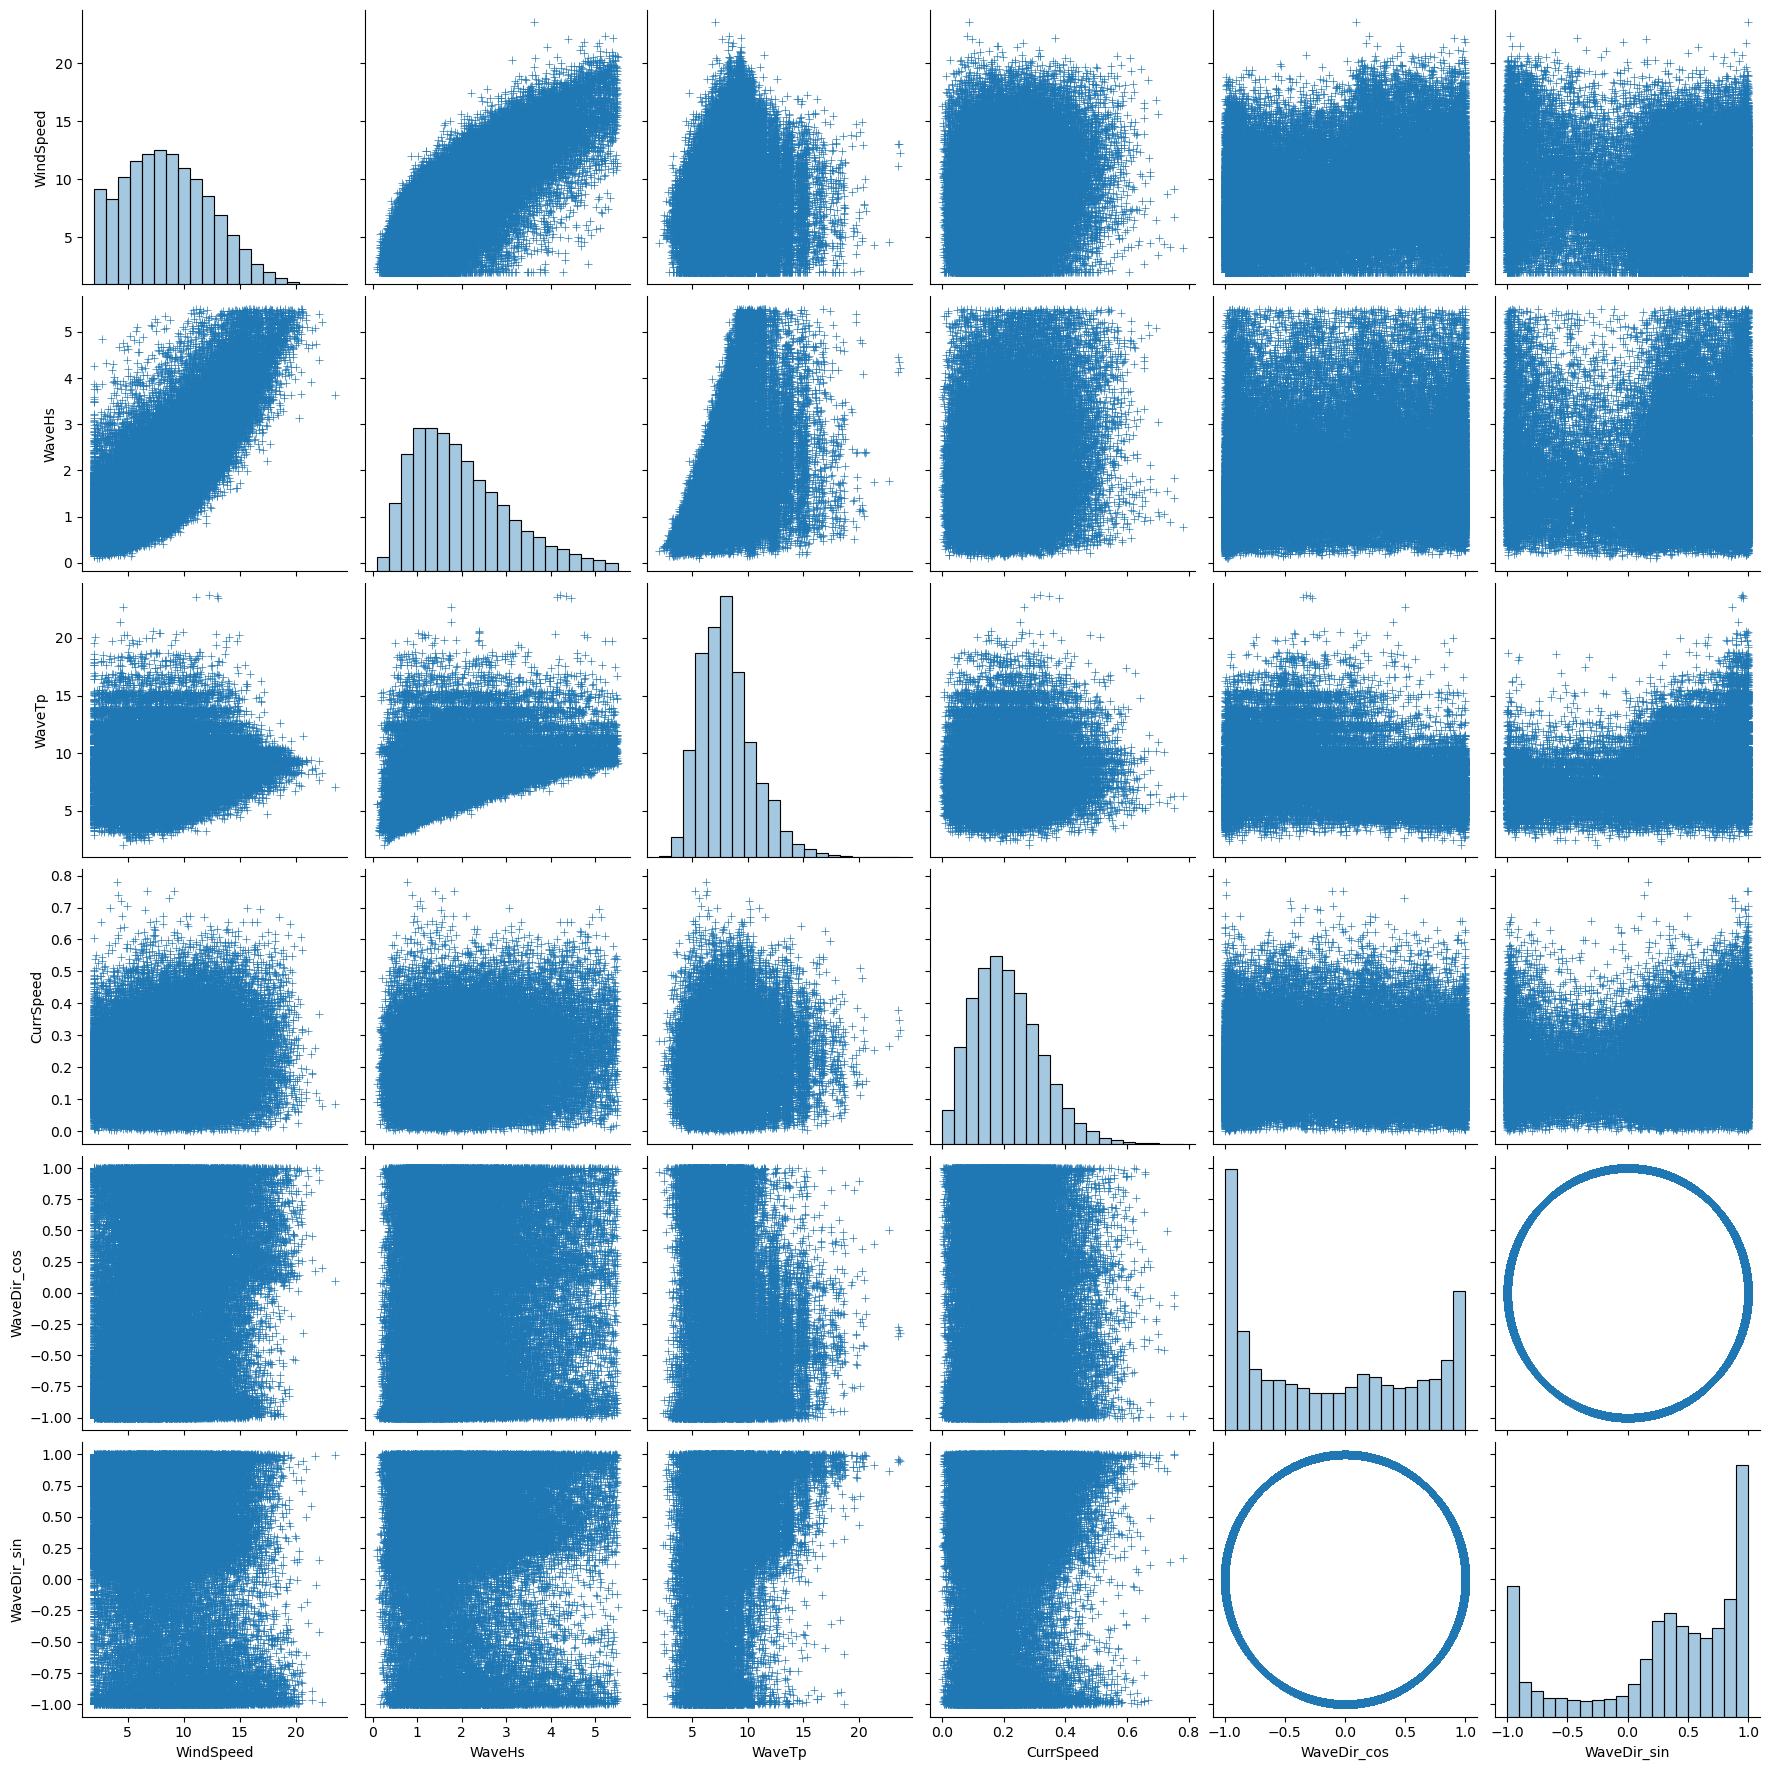

In [32]:
# Select key features for pair plot
key_features = ['WindSpeed', 'WaveHs', 'WaveTp', 'CurrSpeed', "WaveDir_cos", "WaveDir_sin"]

# Create pair plot with enhancements
sns.pairplot(
    data[key_features], 
    markers='+',
    diag_kws={'bins': 20, 'alpha': 0.4},
    height=3
)

plt.savefig('pairplot1.png')
plt.show()

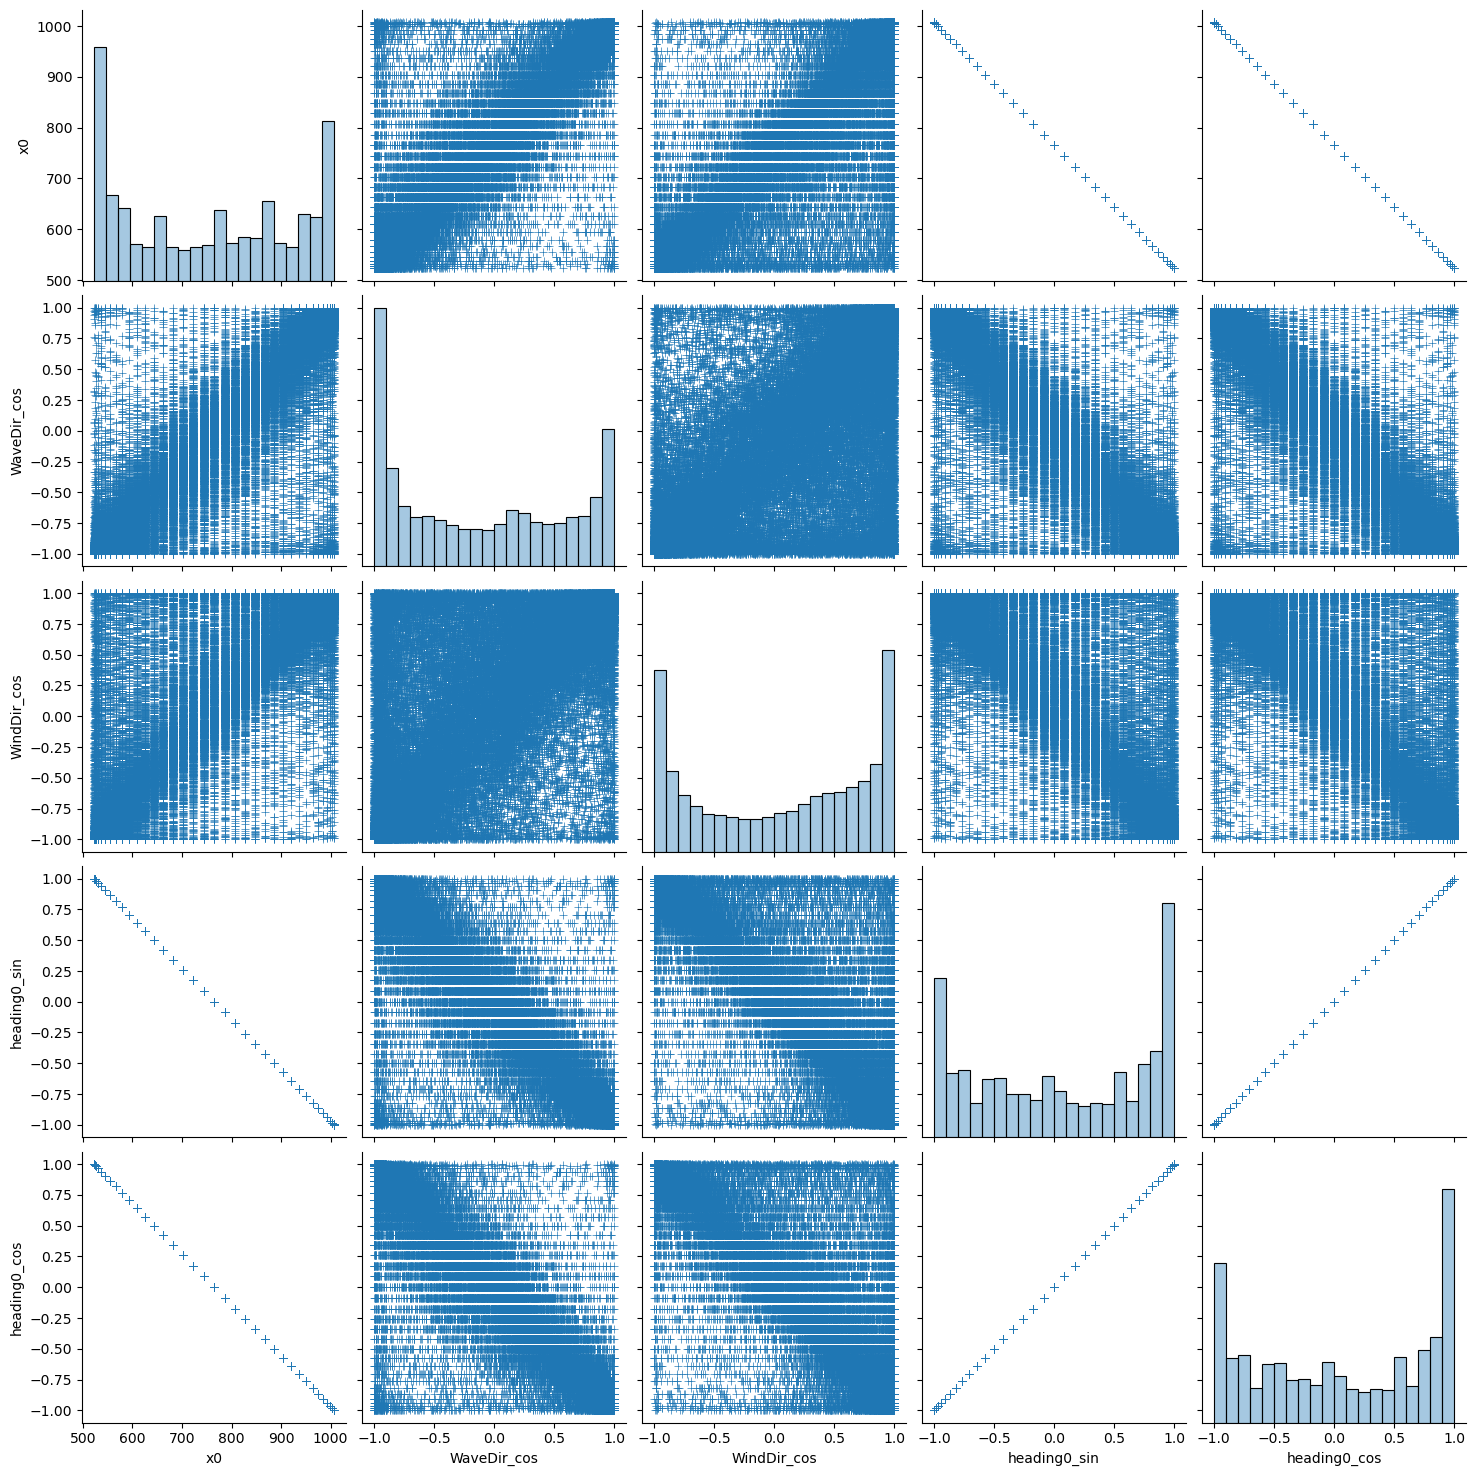

In [33]:
# Select key features for pair plot
key_features = ["x0", "WaveDir_cos", "WindDir_cos", "heading0_sin", "heading0_cos"]

# Create pair plot with enhancements
sns.pairplot(
    data[key_features], 
    markers='+',
    diag_kws={'bins': 20, 'alpha': 0.4},
    height=3
)

plt.savefig('pairplot2.png')
plt.show()

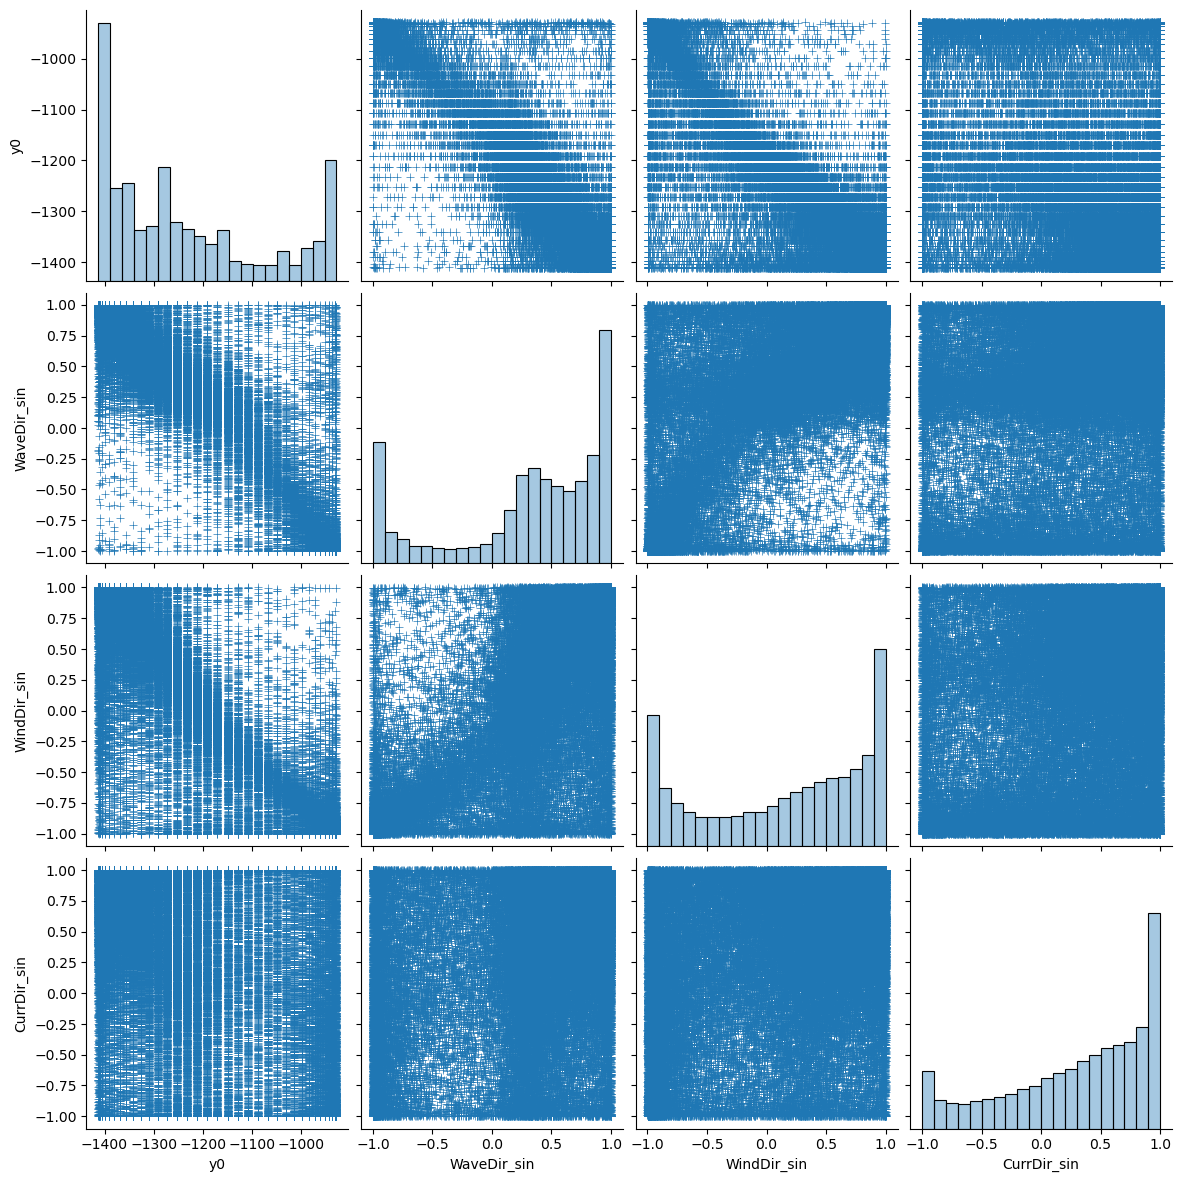

In [36]:
# Select key features for pair plot
key_features = ["y0", "WaveDir_sin", "WindDir_sin", "CurrDir_sin"]

# Create pair plot with enhancements
sns.pairplot(
    data[key_features], 
    markers='+',
    diag_kws={'bins': 20, 'alpha': 0.4},
    height=3
)

plt.savefig('pairplot3.png')
plt.show()

In [37]:
# Select key features for pair plot
key_features = ["WindDir_sin", "WindDir_cos", "WindDir", "WaveDir_sin", "WaveDir_cos", "WaveDir", "CurrDir_sin", "CurrDir_cos", "CurrDir", "WindSpeed", "WaveHs", "WaveTp", "CurrSpeed"]


In [48]:
data_transformed["heading0"] = df_input["heading0"]
data_transformed["WindDir"] = df_input["WindDir"]
data_transformed["WaveDir"] = df_input["WaveDir"]
data_transformed["CurrDir"] = df_input["CurrDir"]

data_transformed

WindSpeed  WaveHs  WaveTp  CurrSpeed       x0        y0  WindDir_sin  \
10730     10.493   1.854  10.375      0.200  963.511 -1309.358     0.191631   
27659     11.648   1.921   5.672      0.147  992.718 -1253.251     0.004136   
4668      11.305   2.092   6.248      0.197  974.868 -1291.530     0.211308   
34204     12.637   2.617   7.524      0.233  950.643 -1326.127     0.338393   
42613     13.298   2.625   6.870      0.359  999.074 -1233.092     0.025776   
...          ...     ...     ...        ...      ...       ...          ...   
14546      7.262   1.374   6.877      0.195  974.868 -1291.530     0.085765   
32963      8.473   0.876   3.847      0.188  526.411 -1212.455    -0.034394   
14846      9.576   1.094   4.201      0.185  545.432 -1272.780     0.439046   
26161      8.871   1.142   4.848      0.056  545.432 -1272.780     0.408777   
43691      8.454   1.142   4.836      0.038  545.432 -1272.780     0.400925   

       WindDir_cos  WaveDir_sin  WaveDir_cos  CurrDir_sin  CurrDir_cos  \
10730     0.981467     0.860431     0.509567     0.970825     0.239788   
27659     0.999991     0.632300     0.774724     0.730532    -0.682879   
4668      0.977420     0.698952     0.715168     0.818120     0.575048   
34204     0.941005     0.772213     0.635364     0.909853    -0.414931   
42613     0.999668     0.267087     0.963672     0.743460    -0.668780   
...            ...          ...          ...          ...          ...   
14546     0.996315     0.813456     0.581626     0.551922     0.833895   
32963    -0.999408     0.745057    -0.667001     0.198496    -0.980102   
14846    -0.898465     0.474841    -0.880072    -0.138776    -0.990324   
26161    -0.912635     0.488545    -0.872539    -0.167801    -0.985821   
43691    -0.916111     0.504528    -0.863396     0.518982    -0.854785   

       heading0_sin  heading0_cos  heading0  WindDir  WaveDir  CurrDir  
10730     -0.819152     -0.819152     215.0   11.048   59.365   76.126  
27659     -0.939693     -0.939693     200.0    0.237   39.220  133.069  
4668      -0.866025     -0.866025     210.0   12.199   44.343   54.897  
34204     -0.766044     -0.766044     220.0   19.779   50.553  114.515  
42613     -0.965926     -0.965926     195.0    1.477   15.491  131.973  
...             ...           ...       ...      ...      ...      ...  
14546     -0.866025     -0.866025     210.0    4.920   54.435   33.499  
32963      0.984808      0.984808     350.0  181.971  131.836  168.551  
14846      0.906308      0.906308     335.0  153.957  151.651  187.977  
26161      0.906308      0.906308     335.0  155.872  150.755  189.660  
43691      0.906308      0.906308     335.0  156.364  149.700  148.736  

[50000 rows x 18 columns]

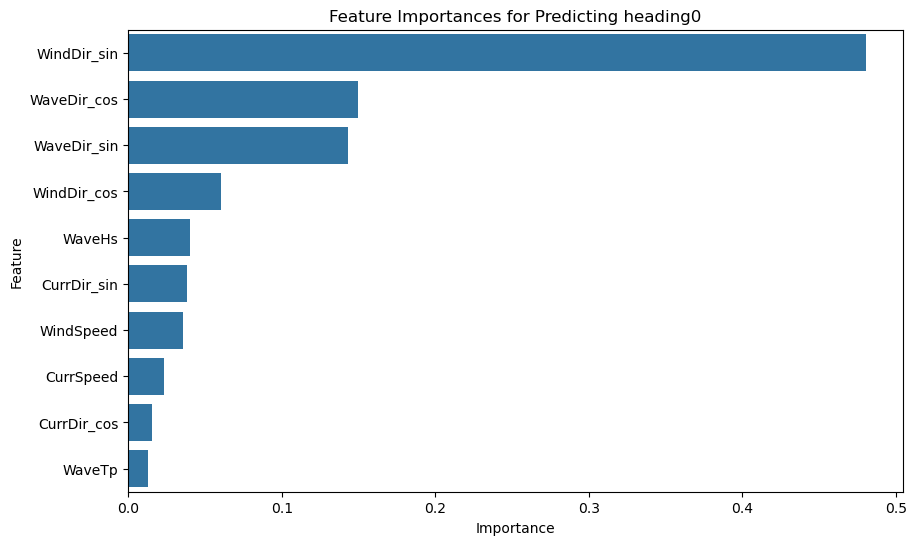

In [52]:
from sklearn.ensemble import RandomForestRegressor


features = data_transformed.drop(columns=["x0", "y0", "heading0_sin", "heading0_cos", "heading0", "WindDir", "WaveDir", "CurrDir"])  # Assuming heading0 is the target variable
target = data['heading0']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Predicting heading0')
plt.show()

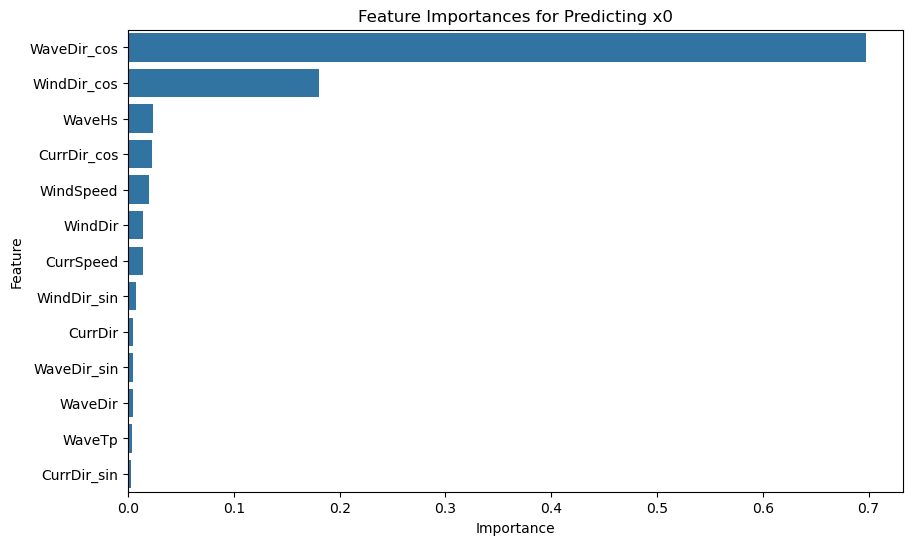

In [53]:
features = data_transformed.drop(columns=["x0", "y0", "heading0_sin", "heading0_cos", "heading0"])  # Assuming heading0 is the target variable
target = data['x0']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Predicting x0')
plt.show()

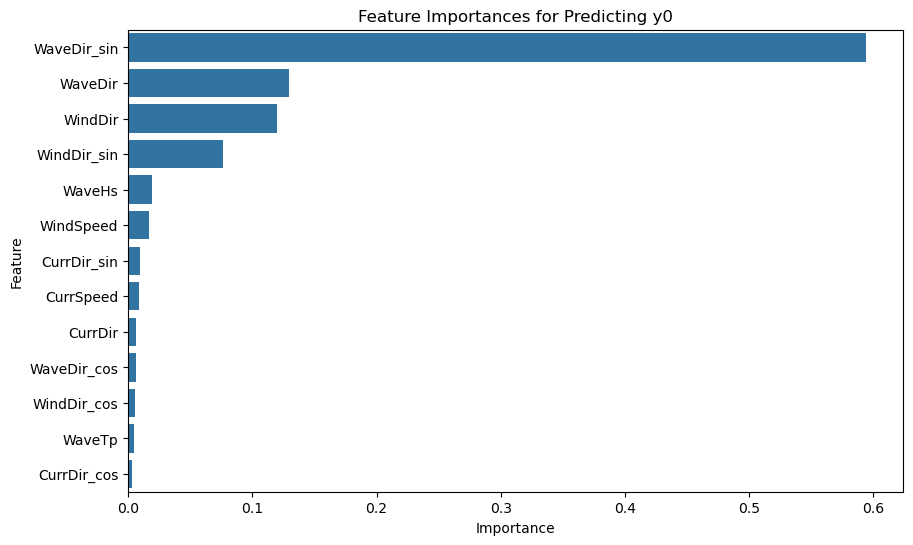

In [54]:
features = data_transformed.drop(columns=["x0", "y0", "heading0_sin", "heading0_cos", "heading0"])  # Assuming heading0 is the target variable
target = data['y0']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Predicting y0')
plt.show()

In [55]:
data_transformed["x_closest"] = df_input["x_closest"]
data_transformed["y_closest"] = df_input["y_closest"]
data_transformed["heading_closest"] = df_input["heading_closest"]

data_transformed

WindSpeed  WaveHs  WaveTp  CurrSpeed       x0        y0  WindDir_sin  \
10730     10.493   1.854  10.375      0.200  963.511 -1309.358     0.191631   
27659     11.648   1.921   5.672      0.147  992.718 -1253.251     0.004136   
4668      11.305   2.092   6.248      0.197  974.868 -1291.530     0.211308   
34204     12.637   2.617   7.524      0.233  950.643 -1326.127     0.338393   
42613     13.298   2.625   6.870      0.359  999.074 -1233.092     0.025776   
...          ...     ...     ...        ...      ...       ...          ...   
14546      7.262   1.374   6.877      0.195  974.868 -1291.530     0.085765   
32963      8.473   0.876   3.847      0.188  526.411 -1212.455    -0.034394   
14846      9.576   1.094   4.201      0.185  545.432 -1272.780     0.439046   
26161      8.871   1.142   4.848      0.056  545.432 -1272.780     0.408777   
43691      8.454   1.142   4.836      0.038  545.432 -1272.780     0.400925   

       WindDir_cos  WaveDir_sin  WaveDir_cos  CurrDir_sin  CurrDir_cos  \
10730     0.981467     0.860431     0.509567     0.970825     0.239788   
27659     0.999991     0.632300     0.774724     0.730532    -0.682879   
4668      0.977420     0.698952     0.715168     0.818120     0.575048   
34204     0.941005     0.772213     0.635364     0.909853    -0.414931   
42613     0.999668     0.267087     0.963672     0.743460    -0.668780   
...            ...          ...          ...          ...          ...   
14546     0.996315     0.813456     0.581626     0.551922     0.833895   
32963    -0.999408     0.745057    -0.667001     0.198496    -0.980102   
14846    -0.898465     0.474841    -0.880072    -0.138776    -0.990324   
26161    -0.912635     0.488545    -0.872539    -0.167801    -0.985821   
43691    -0.916111     0.504528    -0.863396     0.518982    -0.854785   

       heading0_sin  heading0_cos  heading0  WindDir  WaveDir  CurrDir  \
10730     -0.819152     -0.819152     215.0   11.048   59.365   76.126   
27659     -0.939693     -0.939693     200.0    0.237   39.220  133.069   
4668      -0.866025     -0.866025     210.0   12.199   44.343   54.897   
34204     -0.766044     -0.766044     220.0   19.779   50.553  114.515   
42613     -0.965926     -0.965926     195.0    1.477   15.491  131.973   
...             ...           ...       ...      ...      ...      ...   
14546     -0.866025     -0.866025     210.0    4.920   54.435   33.499   
32963      0.984808      0.984808     350.0  181.971  131.836  168.551   
14846      0.906308      0.906308     335.0  153.957  151.651  187.977   
26161      0.906308      0.906308     335.0  155.872  150.755  189.660   
43691      0.906308      0.906308     335.0  156.364  149.700  148.736   

       x_closest  y_closest  heading_closest  
10730    963.511  -1309.358          215.000  
27659    992.718  -1253.251          200.000  
4668     974.868  -1291.530          210.000  
34204    950.643  -1326.127          220.000  
42613    999.074  -1233.092          195.000  
...          ...        ...              ...  
14546    974.868  -1291.530          210.000  
32963    434.102  -1236.069            5.682  
14846    540.745  -1274.739          334.857  
26161    545.432  -1272.780          335.000  
43691    545.432  -1272.780          335.000  

[50000 rows x 21 columns]

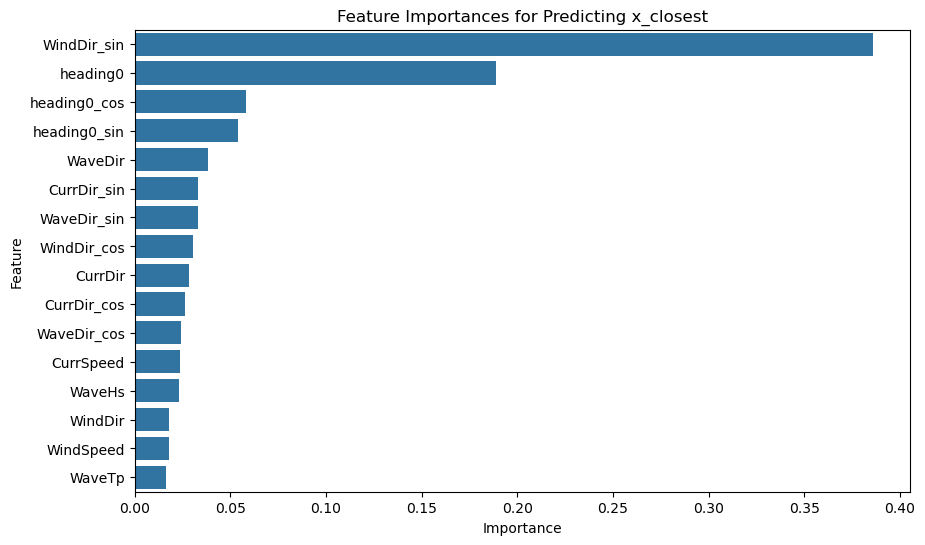

In [56]:
features = data_transformed.drop(columns=["x0", "y0","x_closest", "y_closest", "heading_closest"])  # Assuming heading0 is the target variable
target = data["heading_closest"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Predicting x_closest')
plt.show()

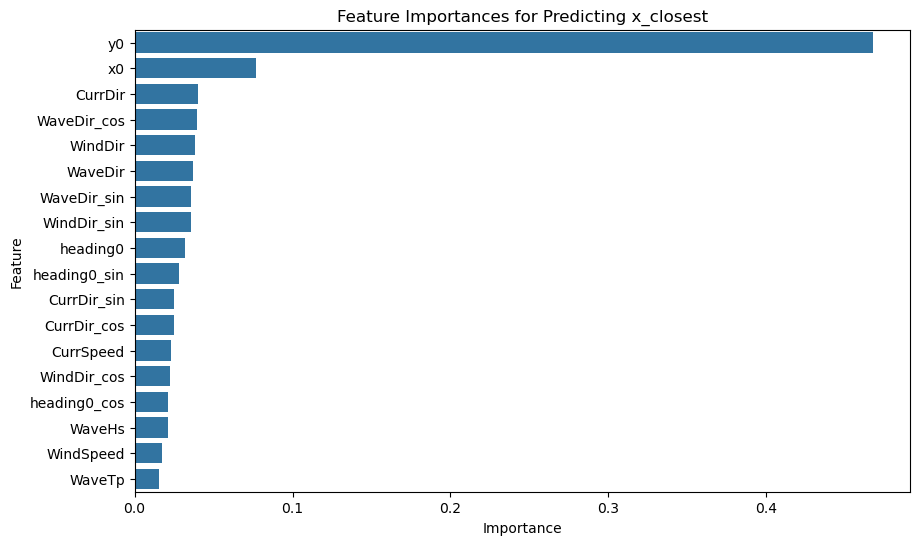

In [57]:
features = data_transformed.drop(columns=["x_closest", "y_closest", "heading_closest"])  # Assuming heading0 is the target variable
target = data["heading_closest"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Predicting x_closest')
plt.show()